# Optimising the parameters of the Von Karman plate

- order: 3

In this notebook we optimise the bending stiffness of a Von Karman plate using backpropagation through time.


In [ ]:
# | hide

from functools import partial

import jax
import jax.numpy as jnp
import jax.scipy.signal as jsig
import numpy as np
import optax
from matplotlib import pyplot as plt
from tqdm import tqdm

from jaxdiffmodal.excitations import create_1d_raised_cosine
from jaxdiffmodal.ftm import (
    PlateParameters,
    damping_term_simple,
)
from jaxdiffmodal.losses import (
    spectral_convergence_loss,
    spectral_wasserstein,
)
from jaxdiffmodal.num_utils import (
    compute_coupling_matrix_numerical,
    multiresolution_eigendecomposition,
)
from jaxdiffmodal.sv import (
    make_vk_nl_fn,
    solve_tf_excitation,
)
from jaxdiffmodal.utils import compute_spectrogram, display_audio_with_title, safe_log

First, we generate a target simulation of the plate. We define the parameters of the plate and the excitation.

In [ ]:
# | code-fold: true

n_modes = 20
sampling_rate = 44100
sampling_period = 1 / sampling_rate
h = 0.004  # grid spacing in the lowest resolution
nx = 50  # number of grid points in the x direction in the lowest resolution
ny = 75  # number of grid points in the y direction in the lowest resolution
levels = 2  # number of grid refinements to perform
amplitude = 0.5
params = PlateParameters(
    E=2e12,
    nu=0.3,
    rho=7850,
    h=5e-4,
    l1=0.2,
    l2=0.3,
    Ts0=100,
)
force_position = (0.05, 0.05)
readout_position = (0.1, 0.1)

In [ ]:
# | code-fold: true

# boundary conditions for the transverse modes
bcs_phi = np.array(
    [
        [1e15, 0],
        [1e15, 0],
        [1e15, 0],
        [1e15, 0],
    ]
)
# boundary conditions for the in-plane modes
bcs_psi = np.array(
    [
        [1e15, 1e15],
        [1e15, 1e15],
        [1e15, 1e15],
        [1e15, 1e15],
    ]
)

psi, zeta_mu_squared, nx_final, ny_final, h_final, psi_norms = (
    multiresolution_eigendecomposition(
        params,
        n_modes,
        bcs_psi,
        h,
        nx,
        ny,
        levels=2,
    )
)

phi, lambda_mu_squared, nx_final, ny_final, h_final, phi_norms = (
    multiresolution_eigendecomposition(
        params,
        n_modes,
        bcs_phi,
        h,
        nx,
        ny,
        levels=2,
    )
)

H = compute_coupling_matrix_numerical(
    psi,
    phi,
    h_final,
    nx_final,
    ny_final,
)
e = params.E / (2 * params.rho)
H = H * np.sqrt(e)
lambda_mu = jnp.sqrt(lambda_mu_squared)

Refining grid to h = 0.002, nx = 100, ny = 150
Refining grid to h = 0.002, nx = 100, ny = 150


In [ ]:
# | code-fold: true

# generate a 1d raised cosine excitation
rc = create_1d_raised_cosine(
    duration=1.0,
    start_time=0.001,
    end_time=0.003,
    amplitude=amplitude,
    sample_rate=44100,
)

phi_reshaped = np.reshape(
    phi,
    shape=(ny_final + 1, nx_final + 1, n_modes),
    order="F",
)

mode_gains_at_pos = phi_reshaped[
    int(force_position[1] * ny_final),
    int(force_position[0] * nx_final),
    :,
]

mode_gains_at_readout = phi_reshaped[
    int(readout_position[1] * ny_final),
    int(readout_position[0] * nx_final),
    :,
]
# the modal excitation needs to be scaled by A_inv and divided by the density
mode_gains_at_pos_normalised = mode_gains_at_pos / params.density
modal_excitation_normalised_short = rc[: 4410 * 3, None] * mode_gains_at_pos_normalised
modal_excitation_normalised_long = rc[:44100, None] * mode_gains_at_pos_normalised

In [ ]:
# | hide

nl_fn = jax.jit(make_vk_nl_fn(jnp.array(H)))


def get_bending_stiffness(pars):
    return pars["bending_stiffness"]


def get_Ts0(pars):
    return pars["Ts0"]


def simulate_vkplate(pars, modal_excitation_normalised):
    omega_mu_squared = (
        get_bending_stiffness(pars) * lambda_mu**2 + get_Ts0(pars) * lambda_mu
    )
    gamma2_mu = damping_term_simple(jnp.sqrt(omega_mu_squared))

    _, modal_sol = solve_tf_excitation(
        gamma2_mu,
        omega_mu_squared,
        modal_excitation_normalised,
        sampling_period,
        nl_fn=nl_fn,
    )

    out_pos = modal_sol @ mode_gains_at_readout
    return out_pos


gt_pars = {
    "bending_stiffness": params.bending_stiffness / params.density,
    "Ts0": params.Ts0 / params.density,
}


def stft(x):
    _, _, zxx = jsig.stft(
        x,
        nperseg=1024,
        noverlap=512,
        padded=False,
        window="hann",
    )
    return zxx.T


out_pos_gt = simulate_vkplate(gt_pars, modal_excitation_normalised_short)
out_pos_gt_long = simulate_vkplate(gt_pars, modal_excitation_normalised_long)
out_pos_gt_fft = stft(out_pos_gt)
out_pos_gt_fft_mag = jnp.abs(out_pos_gt_fft)
out_pos_gt_fft_mag_scale = 1.0 / jnp.max(out_pos_gt_fft_mag)
out_pos_gt_fft_mag = out_pos_gt_fft_mag * out_pos_gt_fft_mag_scale

## Loss landscape
Let's take a small detour to explore how the loss function varies with respect to a single parameter. First define the loss function.

In [ ]:
# | code-fold: true


def combined_loss_fn(
    pars,
    lm_loss_weight=1.0,
    ot_loss_weight=1.0,
    sc_loss_weight=1.0,
    time_loss_weight=1.0,
):
    out_pos = simulate_vkplate(pars, modal_excitation_normalised_short)

    out_pos_fft_mag = jnp.abs(stft(out_pos)) * out_pos_gt_fft_mag_scale

    log_diff = safe_log(out_pos_gt_fft_mag + 1e-10) - safe_log(out_pos_fft_mag + 1e-10)
    lm_loss = jnp.mean(jnp.abs(log_diff))

    ot_loss = jnp.mean(
        jax.vmap(spectral_wasserstein, in_axes=(0, 0, None, None))(
            out_pos_fft_mag,
            out_pos_gt_fft_mag,
            True,
            True,
        )
    )
    time_loss = jnp.mean(jnp.square(out_pos - out_pos_gt))
    sc_loss = spectral_convergence_loss(
        out_pos_fft_mag,
        out_pos_gt_fft_mag,
    )

    combined_loss = (
        lm_loss * lm_loss_weight
        + ot_loss * ot_loss_weight
        + sc_loss * sc_loss_weight
        + time_loss * time_loss_weight
    )
    return combined_loss, (lm_loss, ot_loss, sc_loss, time_loss)

Plot the loss landscape for the bending stiffness

In [ ]:
# | code-fold: true


def compute_losses_for_stiffness(
    bending_stiffness,
    loss_fn,
):
    pars = {
        "bending_stiffness": bending_stiffness,
        "Ts0": params.Ts0 / params.density,
    }
    return loss_fn(pars)


bending_stiffness_normalised_range = jnp.linspace(
    gt_pars["bending_stiffness"] - 4.5,
    gt_pars["bending_stiffness"] + 4.5,
    100,
)

losses_combined, (losses_lm, losses_ot, losses_sc, losses_time) = jax.vmap(
    partial(
        compute_losses_for_stiffness,
        loss_fn=combined_loss_fn,
    )
)(bending_stiffness_normalised_range)

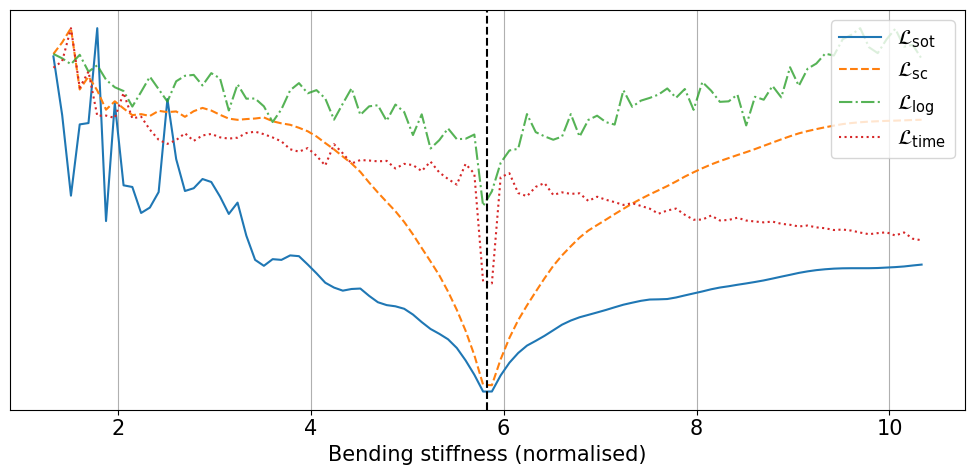

In [ ]:
# | echo: false

plt.rcParams["text.usetex"] = False
plt.rcParams["font.size"] = 15
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(
    bending_stiffness_normalised_range,
    losses_ot / jnp.max(losses_ot),
    label="$\mathcal{L}_{\\text{sot}}$",
)
ax.plot(
    bending_stiffness_normalised_range,
    losses_sc / jnp.max(losses_sc),
    linestyle="--",
    label="$\mathcal{L}_{\\text{sc}}$",
)
ax.plot(
    bending_stiffness_normalised_range,
    losses_lm / jnp.max(losses_lm),
    linestyle="-.",
    label="$\mathcal{L}_{\\text{log}}$",
    alpha=0.8,
)
ax.plot(
    bending_stiffness_normalised_range,
    losses_time / jnp.max(losses_time),
    linestyle=":",
    label="$\mathcal{L}_{\\text{time}}$",
)

ax.set_xlabel("Bending stiffness (normalised)")
ax.set_yticklabels([])
ax.set_yticks([])
ax.axvline(gt_pars["bending_stiffness"], color="k", linestyle="--")
ax.legend(loc="upper right")
ax.grid()
fig.tight_layout()
plt.show()

## Optimise the bending stiffness

Now we optimise the bending stiffness. Starting from an initial value of 10.0

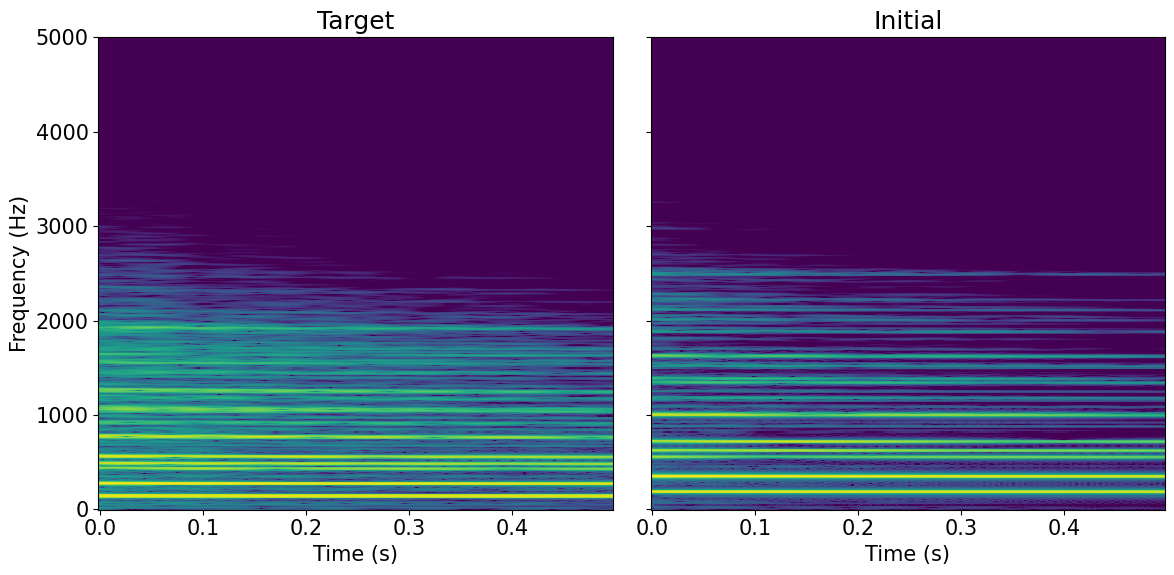

In [ ]:
# | echo: false
pars = {
    "bending_stiffness": 10.0,
    "Ts0": params.Ts0 / params.density,
}
out_pos_pred_initial_long = simulate_vkplate(pars, modal_excitation_normalised_long)

n_fft = 4096
hop_length = 128
max_freq = 16000  # Maximum frequency for spectrogram

scale = 1e5
S_db_x = compute_spectrogram(
    np.array(out_pos_gt_long) * scale,
    sampling_rate,
    n_fft,
    hop_length,
    max_freq,
)
S_db_x_initial = compute_spectrogram(
    np.array(out_pos_pred_initial_long) * scale,
    sampling_rate,
    n_fft,
    hop_length,
    max_freq,
)

# Plot side-by-side spectrograms
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
# Find global min and max for color bar scaling
vmin = S_db_x.min()
vmax = S_db_x.max()


def plot_spectrogram(ax, S_db, title):
    import librosa

    freq_bins = librosa.fft_frequencies(sr=sampling_rate, n_fft=n_fft)
    max_freq_idx = np.sum(freq_bins <= 5000)

    # Calculate time values for x-axis
    times = np.arange(S_db.shape[1]) * hop_length / sampling_rate

    img = ax.pcolormesh(
        times,  # Use time values for x-axis
        freq_bins[:max_freq_idx],  # Use frequency bins for y-axis
        S_db[:max_freq_idx],
        cmap="viridis",
        shading="auto",
        rasterized=True,
        vmin=vmin,
        vmax=vmax,
    )

    # Set title and labels
    ax.set_title(title)
    ax.set_xlabel("Time (s)")

    # Format x-axis ticks to show fewer values
    max_time = times[-1]
    # ax.set_xticks(np.linspace(0, max_time, 5))
    # ax.set_xlim(0, max_time)

    return img


img1 = plot_spectrogram(ax[0], S_db_x, "Target")
img2 = plot_spectrogram(ax[1], S_db_x_initial, "Initial")
ax[0].set_ylabel("Frequency (Hz)")
fig.tight_layout()
plt.show()

display_audio_with_title(out_pos_gt_long, sampling_rate, "Target")
display_audio_with_title(out_pos_pred_initial_long, sampling_rate, "Initial")

Optimisation loop. This might take a while to run, depending on how long is the sequence we want to optimise over and the number of iterations. Here we optimise over a 0.3 second sequence (13230 samples), which is on the longer side for this sort of optimisation.

In [ ]:
# | code-fold: true

learning_rate = 2e-1
iterations = 1000
scheduler = optax.cosine_onecycle_schedule(
    transition_steps=iterations,
    peak_value=learning_rate,
)
optimiser = optax.adam(learning_rate=scheduler)

state = optimiser.init(pars)
value_and_grad = jax.value_and_grad(
    partial(
        combined_loss_fn,
        lm_loss_weight=0.0,
        ot_loss_weight=1.0,
        sc_loss_weight=0.001,
        time_loss_weight=0.0,
    ),
    has_aux=True,
)


@jax.jit
def train_step(pars, state):
    (loss, _), grads = value_and_grad(pars)
    updates, state = optimiser.update(grads, state, pars)
    pars = optax.apply_updates(pars, updates)
    return pars, state, loss


bar = tqdm(range(iterations))
for i in bar:
    pars, state, loss = train_step(pars, state)
    bar.set_description(
        f"Loss: {loss:.3f}, bending stiffness: {pars['bending_stiffness']:.4f}, ground truth: {gt_pars['bending_stiffness']:.4f}",
    )

  0%|          | 0/1000 [00:00<?, ?it/s]2025-04-04 12:06:51.270375: E external/xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng28{k2=1,k3=0} for conv %cudnn-conv.4 = (f32[1,1,14254]{2,1,0}, u8[0]{0}) custom-call(f32[1,1024,15277]{2,1,0} %bitcast.12099, f32[1,1024,1024]{2,1,0} %bitcast.12104), window={size=1024}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", metadata={op_name="jit(train_step)/jit(main)/conv_general_dilated" source_file="/tmp/ipykernel_100446/1261401191.py" source_line=38}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2025-04-04 12:06:51.550709: E external/xla/xla/service/slow_operation_alarm.cc:140] The operation took 1.280406645s
Trying algorithm eng28{k2=1,k3=0} for conv %cudnn-conv.4 = (f32[1,1,14254]{2,1,0}, u8[0]{0}) custom-call(f32[

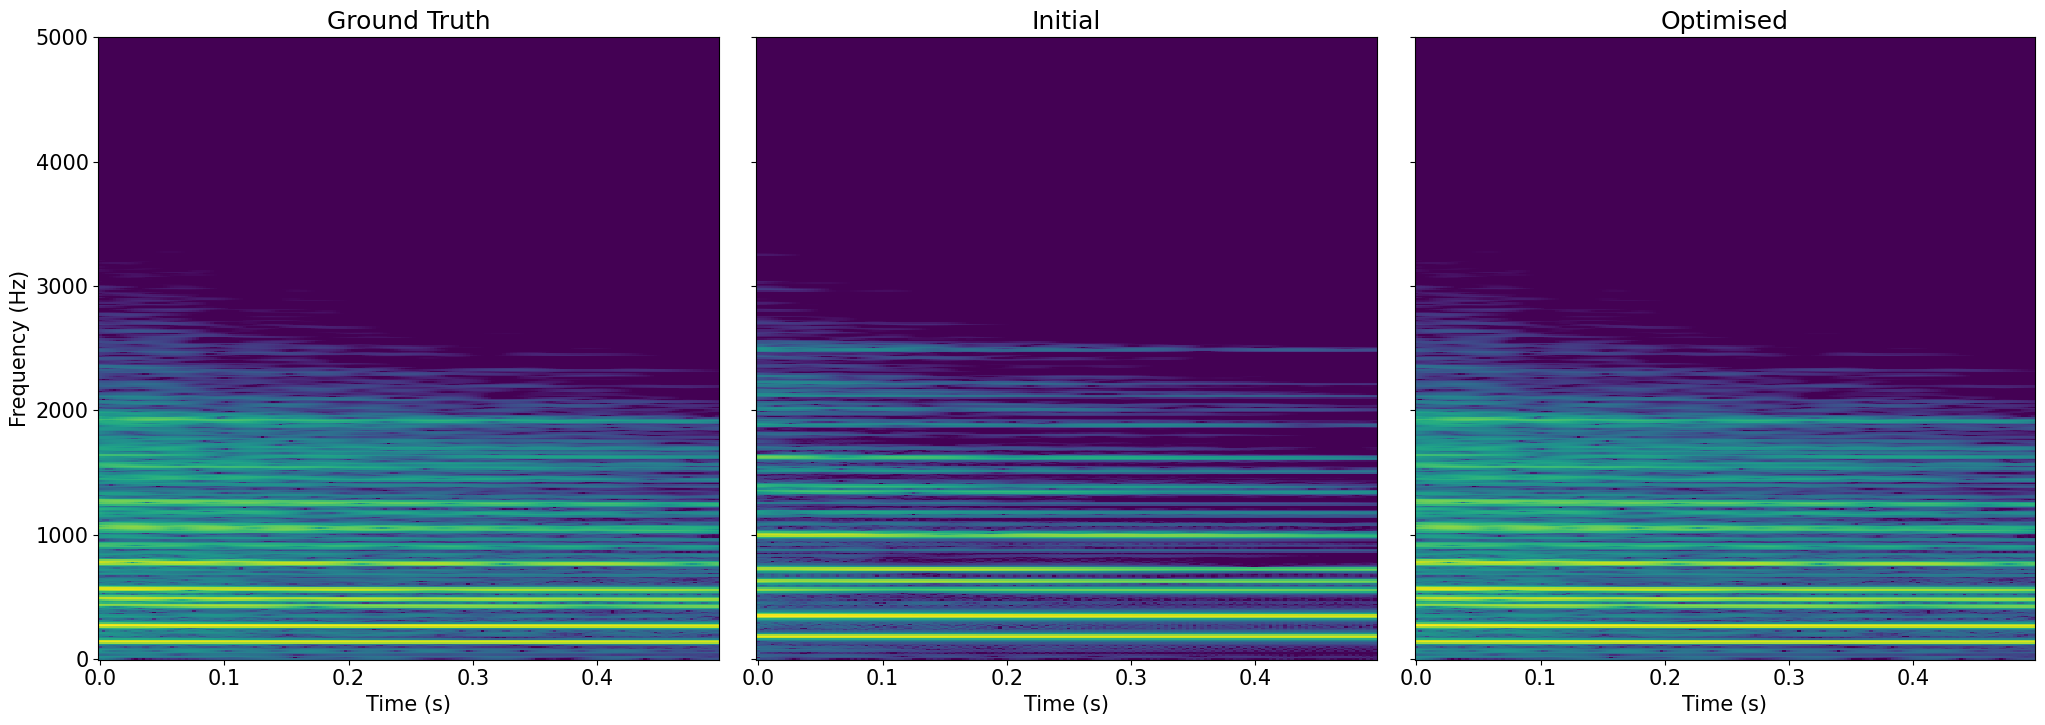

In [ ]:
# | echo: false

out_pos_pred_long = simulate_vkplate(pars, modal_excitation_normalised_long)

scale = 1e8
S_db_x = compute_spectrogram(
    np.array(out_pos_gt_long) * scale,
    sampling_rate,
    n_fft,
    hop_length,
    max_freq,
)
S_db_x_initial = compute_spectrogram(
    np.array(out_pos_pred_initial_long) * scale,
    sampling_rate,
    n_fft,
    hop_length,
    max_freq,
)
S_db_x_hat = compute_spectrogram(
    np.array(out_pos_pred_long) * scale,
    sampling_rate,
    n_fft,
    hop_length,
    max_freq,
)
# Find global min and max for color bar scaling
vmin = min(S_db_x.min(), S_db_x_hat.min())
vmax = max(S_db_x.max(), S_db_x_hat.max())

# Plot side-by-side spectrograms
fig, ax = plt.subplots(1, 3, figsize=(6.9 * 3, 2.5 * 3), sharey=True)
img1 = plot_spectrogram(ax[0], S_db_x, "Ground Truth")
img2 = plot_spectrogram(ax[1], S_db_x_initial, "Initial")
img3 = plot_spectrogram(ax[2], S_db_x_hat, "Optimised")
ax[0].set_ylabel("Frequency (Hz)")
fig.tight_layout()
plt.show()

display_audio_with_title(out_pos_gt_long, sampling_rate, "Target")
display_audio_with_title(out_pos_pred_long, sampling_rate, "Optimised")

## Multistart parallel optimisation

We can also optimise over a larger range of initial bending stiffness values, using parallel multiple starts in parallel. Here we use 50 random initial values between 2 and 50. NB: with longer sequences, this will take longer to run also because the XLA compilation will take longer to find an appropriate implementation because of the STFT.

In [ ]:
# | code-fold: true

value_and_grad = jax.value_and_grad(
    partial(
        combined_loss_fn,
        lm_loss_weight=0.0,
        ot_loss_weight=1.0,
        sc_loss_weight=0.001,
        time_loss_weight=0.0,
    ),
    has_aux=True,
)


def losses_and_grads_for_single_stiffness(bending_stiffness):
    pars = {
        "bending_stiffness": bending_stiffness,
        "Ts0": params.Ts0 / params.density,
    }

    (loss, _), grads = value_and_grad(pars)

    # return loss and gradient for bending stiffness only
    return loss, grads["bending_stiffness"]


compute_vec_loss_grad = jax.vmap(losses_and_grads_for_single_stiffness)

# Generate starting points
num_starts = 50
start_points = jnp.linspace(2.0, 50.0, num_starts)

learning_rate = 1e-2
iterations = 100
scheduler = optax.cosine_onecycle_schedule(
    transition_steps=iterations,
    peak_value=learning_rate,
)
optimiser = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.adam(learning_rate=scheduler),
)
opt_state = optimiser.init(start_points)


@jax.jit
def train_step(pars, state):
    losses, grads = compute_vec_loss_grad(pars)
    updates, state = optimiser.update(grads, state, pars)
    pars = optax.apply_updates(pars, updates)
    return pars, state, losses


bar = tqdm(range(iterations))
for i in bar:
    start_points, opt_state, losses = train_step(start_points, opt_state)

    best_idx = jnp.argmin(losses)
    best_loss = losses[best_idx]
    best_param = start_points[best_idx]
    bar.set_description(f"Best loss: {best_loss:.6f}, Best param: {best_param:.6f}")

# Get final results
final_losses, _ = compute_vec_loss_grad(start_points)
best_idx = jnp.argmin(final_losses)
best_param = start_points[best_idx]
best_loss = final_losses[best_idx]

print(f"Best bending stiffness found: {best_param:.6f}")
print(f"Ground truth: {gt_pars['bending_stiffness']:.6f}")
print(f"Best loss: {best_loss:.6f}")

  0%|          | 0/100 [00:00<?, ?it/s]2025-04-04 11:57:23.800760: E external/xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng55{k2=8,k13=1,k14=3,k18=1,k22=0,k23=0} for conv %cudnn-conv.4 = (f32[50,1,14254]{2,1,0}, u8[0]{0}) custom-call(f32[50,1024,15277]{2,1,0} %bitcast.12196, f32[1,1024,1024]{2,1,0} %bitcast.12201), window={size=1024}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", metadata={op_name="jit(train_step)/jit(main)/conv_general_dilated" source_file="/tmp/ipykernel_100446/1261401191.py" source_line=38}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2025-04-04 11:57:27.647765: E external/xla/xla/service/slow_operation_alarm.cc:140] The operation took 4.84707795s
Trying algorithm eng55{k2=8,k13=1,k14=3,k18=1,k22=0,k23=0} for conv %cudnn-conv.4 = 

Best bending stiffness found: 5.832441
Ground truth: 5.832808
Best loss: 0.000005
